Training pure-Python EC cancellation bench… MODE: DETERMINISTIC


100%|██████████| 50000/50000 [00:08<00:00, 6091.96it/s]


✓ DETERMINISTIC training done

=== BENCHMARK STATISTICS ===
Min: 0.4650
Max: 0.5550
Mean: 0.5064
StdDev: 0.0214

✓ Data saved to ec_flat_deterministic_20251207_130348.csv


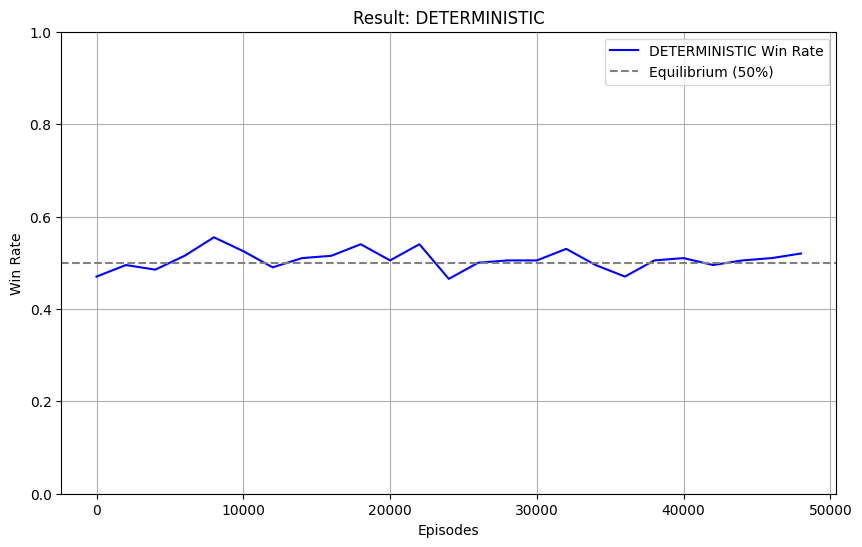

In [3]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from datetime import datetime

# CRITICAL: Set the seed for reproducibility
random.seed(42)
np.random.seed(42)

# ==========================================
# 2. CONFIGURATION
# ==========================================
# CHANGE THIS TO: "CLASSICAL", "STOCHASTIC", or "DETERMINISTIC"
BENCHMARK_MODE = "DETERMINISTIC"
# ==========================================

print(f"Training pure-Python EC cancellation bench… MODE: {BENCHMARK_MODE}")

# ==========================================
# 3. HYPER-PARAMETERS
# ==========================================
N_EPISODES = 50_000
EVAL_FREQ = 2_000
PAIRED = 100
epsilon, alpha, gamma = 0.1, 0.1, 0.99
results = {"episode": [], "p1_win_rate": []}

# ==========================================
# 4. BOARD & STATE
# ==========================================
BOARD = np.zeros((8, 8), dtype=int)
for c in range(8):
    for r in [0, 2]: BOARD[r, c] = 2
    for r in [5, 7]: BOARD[r, c] = 1
Q = {}
entropy_global_clock = 0

# ==========================================
# 5. HELPER FUNCTIONS
# ==========================================
def state_key(board): return (0,)
def legal_moves(board, player): return list(range(35))

def choose_action(state, moves, epsilon, player_idx):
    if player_idx == 1: return random.choice(moves) # P2 Random
    if random.random() < epsilon: return random.choice(moves)
    return max(moves, key=lambda a: Q.get((state, a), 0.0))

def entropy_menu(board, attacker_val, defender_val, choice):
    if choice == 0: return board
    if choice == 1: # Remove
        a_pieces = np.argwhere(board == attacker_val)
        d_pieces = np.argwhere(board == defender_val)
        if len(d_pieces) > 0: board[tuple(d_pieces[0])] = 0
        if len(a_pieces) > 0: board[tuple(a_pieces[0])] = 0
        return board
    if choice == 2: # Swap
        a_list = np.argwhere(board == attacker_val)
        d_list = np.argwhere(board == defender_val)
        if len(a_list) > 0 and len(d_list) > 0:
            a_pos, d_pos = a_list[0], d_list[0]
            board[a_pos[0], a_pos[1]], board[d_pos[0], d_pos[1]] = \
            board[d_pos[0], d_pos[1]], board[a_pos[0], a_pos[1]]
        return board

# ==========================================
# 6. TRAINING LOOP
# ==========================================
for ep in tqdm(range(N_EPISODES)):
    board = BOARD.copy()
    cur_player_idx = 0

    # Track the "Strategic State" (The Proxy)
    # 0=Normal, 1=Damped, 2=Inverted
    episode_vector_state = 0

    while True:
        cur_piece_val = cur_player_idx + 1
        opp_piece_val = 2 if cur_player_idx == 0 else 1

        moves = legal_moves(board, cur_player_idx)
        action = choose_action(state_key(board), moves, epsilon, cur_player_idx)

        # Agency: Action 0 is skilled
        if action == 0: capture_chance = 0.30
        else: capture_chance = 0.02

        if random.random() < capture_chance:
            # 1. Capture
            opp_pieces = np.argwhere(board == opp_piece_val)
            if len(opp_pieces) > 0: board[tuple(opp_pieces[0])] = 0

            # 2. Entropy
            if BENCHMARK_MODE == "STOCHASTIC": c = random.choice([0, 1, 2])
            elif BENCHMARK_MODE == "DETERMINISTIC":
                c = entropy_global_clock % 3
                entropy_global_clock += 1
            elif BENCHMARK_MODE == "CLASSICAL": c = 0

            board = entropy_menu(board, cur_piece_val, opp_piece_val, c)

            # 3. Track Strategic Damage
            if c == 2: episode_vector_state = 2
            elif c == 1 and episode_vector_state != 2: episode_vector_state = 1

        if random.random() < 0.05: break
        cur_player_idx = 1 - cur_player_idx

    # Reward Calculation with Proxy
    p1 = np.sum(board == 1)
    p2 = np.sum(board == 2)
    if p1 > p2: base = 1.0
    elif p2 > p1: base = -1.0
    else: base = 0.0

    if episode_vector_state == 0: final = base
    elif episode_vector_state == 1: final = base * 0.1
    elif episode_vector_state == 2: final = base * -1.0

    # Update Q
    state = state_key(board)
    old_q = Q.get((state, action), 0.0)
    Q[(state, action)] = old_q + alpha * (final + gamma * 0.0 - old_q)

    # Evaluation
    if ep % EVAL_FREQ == 0:
        wins = 0
        for _ in range(PAIRED):
            b = BOARD.copy()
            e_idx = 0
            e_vec = 0
            while True:
                cur = e_idx + 1
                opp = 2 if e_idx == 0 else 1
                ms = legal_moves(b, e_idx)

                if e_idx == 1: act = random.choice(ms)
                else: act = max(ms, key=lambda a: Q.get((state_key(b), a), 0.0))

                if act == 0: cp = 0.30
                else: cp = 0.02

                if random.random() < cp:
                    ops = np.argwhere(b == opp)
                    if len(ops) > 0: b[tuple(ops[0])] = 0

                    if BENCHMARK_MODE == "STOCHASTIC": ec = random.choice([0, 1, 2])
                    elif BENCHMARK_MODE == "DETERMINISTIC":
                        ec = entropy_global_clock % 3
                        entropy_global_clock += 1
                    elif BENCHMARK_MODE == "CLASSICAL": ec = 0

                    b = entropy_menu(b, cur, opp, ec)
                    if ec == 2: e_vec = 2
                    elif ec == 1 and e_vec != 2: e_vec = 1

                if random.random() < 0.05: break
                e_idx = 1 - e_idx

            # Scoring
            p1c = np.sum(b == 1)
            p2c = np.sum(b == 2)
            if p1c > p2c: rs = 1
            elif p2c > p1c: rs = -1
            else: rs = 0

            if e_vec == 2: fs = rs * -1
            elif e_vec == 1: fs = rs * 0.1
            else: fs = rs

            if fs > 0: wins += 1
            elif fs == 0: wins += 0.5
            else: wins += 0
        results["episode"].append(ep)
        results["p1_win_rate"].append(wins / PAIRED)

print(f"✓ {BENCHMARK_MODE} training done")

# ==========================================
# 7. STATISTICS & SAVE
# ==========================================
rates = results["p1_win_rate"]
stats = {
    "Min": np.min(rates),
    "Max": np.max(rates),
    "Mean": np.mean(rates),
    "StdDev": np.std(rates)
}

print("\n=== BENCHMARK STATISTICS ===")
for k, v in stats.items():
    print(f"{k}: {v:.4f}")
print("============================\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df = pd.DataFrame(results)
filename = f"ec_flat_{BENCHMARK_MODE.lower()}_{timestamp}.csv"
df.to_csv(filename, index=False)
print(f"✓ Data saved to {filename}")

plt.figure(figsize=(10, 6))
plt.plot(results["episode"], results["p1_win_rate"], label=f"{BENCHMARK_MODE} Win Rate", color='blue')
plt.axhline(y=0.5, color='gray', linestyle='--', label="Equilibrium (50%)")
plt.ylim(0.0, 1.0)
plt.title(f"Result: {BENCHMARK_MODE}")
plt.xlabel("Episodes")
plt.ylabel("Win Rate")
plt.legend()
plt.grid(True)
plt.show()

# New Section